# Tutorial: Image Classification and its Application in Generative Adversarial Networks
# It's a Bird. It's a Plane. It's SUPER... GAN!

**Knowledge Prerequisites**: This tutorial presumes a basic of simple neural networks (e.g. multilayer perceptrons) and of generic gradient descent optimisation algorithms.

## Abstract

This tutorial will detail the creation, development and training of both a Convolutional Neural Network (CNN) and a Generative Adversarial Network (GAN). It includes preprocessing the data, the selection process of our loss functions and optimizers, and the training loops of each. After proving that the CNN classifier is sufficiently equipped for image classification using bird and plane datasets, we will utilise that same structure for part of our GAN. The tutorial will also go over the performance of our networks by measuring the accuracy of our CNN and presenting bird images that the GAN has attempted to create.

## Table of Contents

1. [Learning Objectives](#Learning-Objectives)
2. [Understanding the CIFAR-10 Dataset](#Understanding-the-CIFAR-10-Dataset)
3. [Importing Required Libraries](#Importing-Required-Libraries)
4. [Data Preprocessing](#Data-Pre-processing)
    - [Loading and Transforming the Dataset](#Loading-and-Transforming-the-Dataset)
    - [Filtering the Dataset for Birds and Planes](#Filtering-the-Dataset-for-Birds-and-Planes)
5. [Data Visualisation](#Data-Visualisation)
6. [Creating a Simple CNN for Image Classification](#Creating-a-Simple-CNN-for-Image-Classification)
    - [Basics of Convolutional Neural Networks (CNNs)](#Basics-of-Convolutional-Neural-Networks-CNNs)
    - [Creating Dataloaders](#Creating-Dataloaders)
    - [Defining the Simple CNN Architecture](#Defining-the-Simple-CNN-Architecture)
    - [Defining the Loss Function and Optimizer](#Defining-the-Loss-Function-and-Optimizer)
    - [Training the Image Classifier](#Training-the-Image-Classifier)
    - [Evaluating Model Accuracy and Loss](#Evaluating-Model-Accuracy-and-Loss)
7. [Hyperparameter Optimisation: Adding Complexity to our Image Classifier](#Hyperparameter-Optimisation:-Adding-Complexity-to-our-Image-Classifier)
    - [Experimenting with Different Architectures](#Experimenting-with-Different-Architectures)
    - [Adjusting Learning Rates and Other Parameters](#Adjusting-Learning-Rates-and-Other-Parameters)
    - [Evaluating Model Performance](#Evaluating-Model-Performance)
8. [Applying our Optimised Image Classification Model in a GAN](#Applying-our-Optimised-Image-Classification-Model-in-a-GAN)
    - [Introduction to Generative Adversarial Networks](#Introduction-to-Generative-Adversarial-Networks)
    - [Defining the Generator Model](#Defining-the-Generator-Model)
    - [Defining the Discriminator Model](#Defining-the-Discriminator-Model)
    - [Training the GAN](#Training-the-GAN)
    - [Visualising GAN Training Process](#Visualising-GAN-Training-Process)
9. [Conclusion](#Conclusion)
    - [Distinctive Features](#Distinctive-Features)
10. [References](#References)

## Learning Objectives

- Become familiarised with the CIFAR-10 dataset, and its application to image classifcation models.
- Understand the importance of data preprocessing and how it is performed.
- Learn how to define a CNN model suitable for image classification tasks, while also understanding the structure and importance of different layers.
- Learn how to implement the training of a CNN model, including the forward pass, loss computation, backpropagation and parameter updates.
- Learn how to analyse and visualise the models performance using matplotlib. 
- Learn to identify common issues that may arise during the training of our model, such as overfitting and underfitting, and how to mitigate these factors.

## Understanding the CIFAR-10 Dataset

**Dataset:** https://www.cs.toronto.edu/~kriz/cifar.html <sup>[1]</sup>

The CIFAR-10 dataset consists of 60,000 32x32 colour images, with 6,000 images per class. It is split into training and testing sets with a 5:1 ratio, giving us 5000 and 1000 images in the training and test set, respectively. The images, however, are only 32x32 pixels large, making the dataset manageable for training models with limited computation. Nevertheless, this can still present challenges, as our lack of detail may make it harder for models to distinguish between our planes and birds.

## Importing required libraries

PyTorch for building and training the neural network.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader

If you have a CUDA enabled GPU, and have the CUDA toolkit installed (see: https://developer.nvidia.com/cuda-toolkit), you may be able to utilise it for faster training times by defining it as your device and offloading work to it later. It is worth considering that this may not always speed things up, since the cost of offloading the data can be more than the time saved by the GPU utilisation. To get this working you may need to install a compatible version of the 'cuda toolkit' by Nvidia and have a supported version enabled. 

In [2]:
print(torch.cuda.is_available())


if(torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

True


Torchvision library for computer vision models and preprocessing of image data:

In [3]:
import torchvision
from torchvision import utils, transforms

Numpy for further data manipulation and preprocessing:

In [4]:
import numpy as np

Matplotlib for data visualisation:

In [5]:
import matplotlib.pyplot as plt

Time for the monitoring of runtimes:

In [6]:
import time

## Data Pre-processing

### Loading and transforming the dataset

First we can define a transform for the image data we are about to import, turning them into tensors. This turns the image into an understandable input for our model, while they also provide the benefit of supporting GPU acceleration. Additionally, we want to normalise the pixel values in our tensor to a limited range, as neural networks process inputs using small weight values and using larger integers can disrupt or slow down the learning process<sup>[2]</sup>. Here I have chosen a range of [-1,1], because it exploits the benefits of zero-centred data and negative symmetry for model convergence, though you can also use a range of [0,1] instead.

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), #Converts 32x32 RGB images to tensors, automatically normalising to the range 0-1
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Converts range from [0, 1] to [-1, 1] 

Next we load the train and test dataset from the CIFAR-10, while also applying the transform:

In [8]:
# CIFAR-10 Dataset
# download code as from source [3]

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

### end of source [3]
# source [3] https://pytorch.org/vision/0.17/generated/torchvision.datasets.CIFAR10.html

Files already downloaded and verified
Files already downloaded and verified


Now we can view the properties of the datasets we have imported:

In [9]:
print("Train-set size:", len(trainset))
print("Test-set size:", len(testset))
print("Classes: ", trainset.classes)

Train-set size: 50000
Test-set size: 10000
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


As previously stated, the train-to-test set ratio is 5:1, and has already been split accordingly for us within the CIFAR-10 torchvision dataset.\
**Note**: If you are using a different dataset, you may have to manually split it yourself. You could do this with the same 5:1 ratio in with a dataset of 6,000 images like this: 
> trainset, testset = torch.utils.data.random_split(dataset, [50000, 10000])

### Filtering the Dataset for Birds and Planes

From the output above, we have identified that this dataset currently consists of 10 seperate classes. For our purposes, we only require the subsets of airplanes and birds. For this reason, we will filter out the other classes. Also, since we are conducting a binary classification, it is helpful to change the class labels to 1 and 0 for ease as demonstrated in the code below:

In [10]:
#0 and 2 correspond to the index of the 'airplane' and 'bird' classes
filtered_classes = [0, 2]

train_indices = [i for i, label in enumerate(trainset.targets) if label in filtered_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in filtered_classes]

#Convert label #2 -> #1 so we have labels 0 and 1 for binary image classification
for i in train_indices: trainset.targets[i] = 1 if trainset.targets[i] == 2 else trainset.targets[i]
for i in test_indices: testset.targets[i] = 1 if testset.targets[i] == 2 else testset.targets[i]

trainset_filtered = Subset(trainset, train_indices)
testset_filtered = Subset(testset, test_indices)

Upon filtering the dataset, we can view the properties of the new subset below. Notice how the train and test sets have shrunk to 20% of the original size, as we have removed the 80% we are not using.

In [11]:
print("Train-set size:", len(trainset_filtered))
print("Test-set size:", len(testset_filtered))
print([trainset.classes[i] for i in filtered_classes])


Train-set size: 10000
Test-set size: 2000
['airplane', 'bird']


## Data Visualisation

To ensure that the data has been handled and imported correctly, we can utilise MatPlotLib with NumPy for their data visualisation libraries. To observe said data we will pick 5 random images from each class.

In [12]:
#images, labels = trainset_filtered
images = np.array([image for image, _ in trainset_filtered])
labels = np.array([label for _, label in trainset_filtered])

bird_images = images[labels == 1]
plane_images = images[labels == 0]

bird_indices = [i for i, label in enumerate(labels) if label == 1] #Gets all the indicies of birds
rand_bird_indices = np.random.choice(bird_indices, 5, replace=False) #Chooses 5 at random

plane_indices = [i for i, label in enumerate(labels) if label == 0] #Gets all the indicies of birds
rand_plane_indices = np.random.choice(plane_indices, 5, replace=False) #Chooses 5 at random

Next we can observe the images and labels in this dataset to ensure that it is working as expected. As we have normalised the images in tensor form, we will need to undo this normalisation to view them in their original form. Below you can see 5 random samples from each dataset, to understand what we are working with.

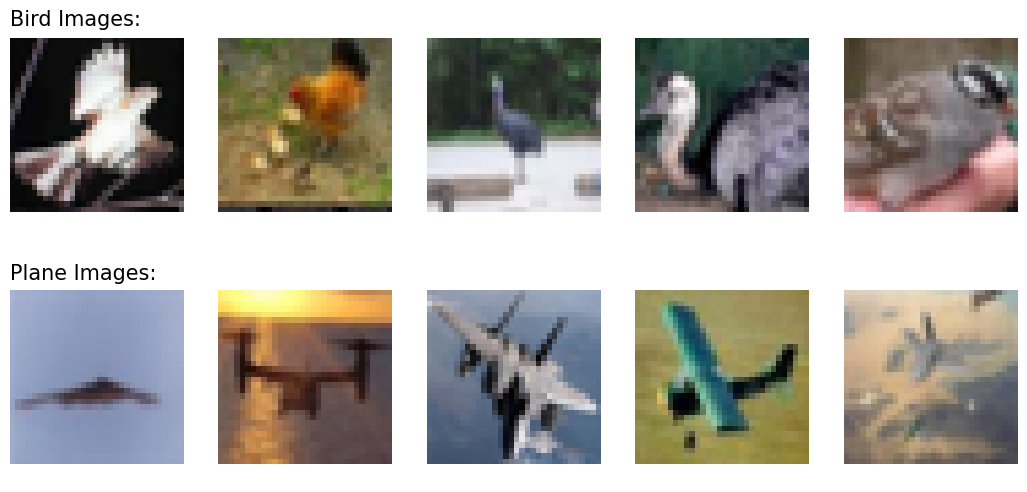

In [13]:
def de_normalise_image(image):
    return(image*0.5 + 0.5) #de-normalize from range [-1,1] to [-1*0.5+0.5, 1*0.5+0.5] = [0,1]

fig = plt.figure(figsize=(13,6))

gs = fig.add_gridspec(2,5) #2 rows, 5 columns for the images

for i in range(5):
    # First row
    ax1 = fig.add_subplot(gs[0, i])
    ax1.axis('off')
    ax1.imshow(de_normalise_image(images[rand_bird_indices[i]].transpose((1, 2, 0))))
    
    # Second row, directly below the first row
    ax2 = fig.add_subplot(gs[1, i])
    ax2.axis('off')
    ax2.imshow(de_normalise_image(images[rand_plane_indices[i]].transpose((1, 2, 0))))

ax_text = fig.add_subplot()
ax_text.axis('off')  # Hide the axes
ax_text.text(0, 1, 'Bird Images:', horizontalalignment='left', verticalalignment='center', transform=ax_text.transAxes, fontsize=15)
ax_text = fig.add_subplot()
ax_text.axis('off')  # Hide the axes
ax_text.text(0, 0.45, 'Plane Images:', horizontalalignment='left', verticalalignment='center', transform=ax_text.transAxes, fontsize=15)

plt.show()

We can also view the pixel intensity distribution of our images <sup>[4]</sup>. This will verify if we have correctly normalised the data, while also giving us some insight into what said data looks like.

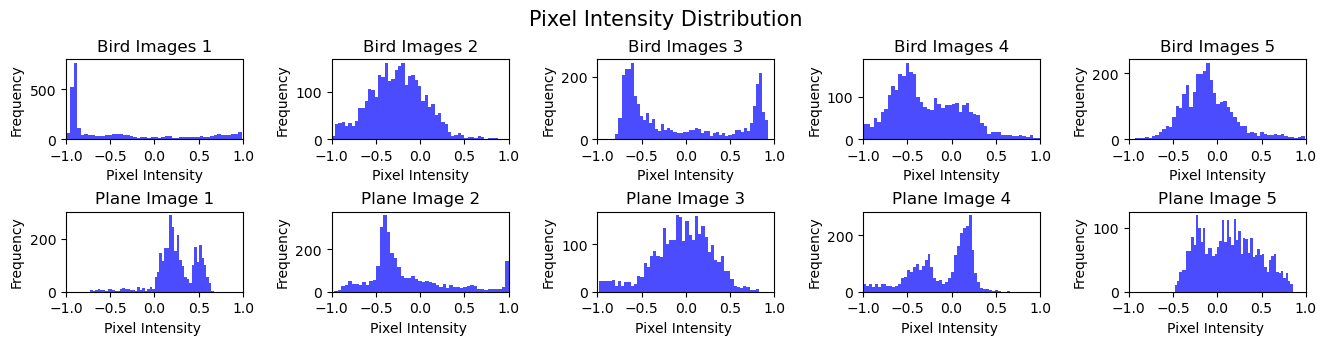

In [14]:
#Histograms of random images
fig1 = plt.figure(figsize=(16,5))

gs = fig1.add_gridspec(3,5)

for i in range(5):
     
    ax1 = fig1.add_subplot(gs[0, i])
    ax1.hist(images[rand_bird_indices[i]].flatten(), bins=50, color='blue', alpha=0.7)
    ax1.set_xlabel('Pixel Intensity')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Bird Images {i+1}')
    ax1.set_xlim([-1, 1])  # Not all images reach both ends of the pixel intensity spectrum, I have extended the axis to the minimums and maximums possible for consistency in images

    ax2 = fig1.add_subplot(gs[1, i])
    ax2.hist(images[rand_plane_indices[i]].flatten(), bins=50, color='blue', alpha=0.7)
    ax2.set_xlabel('Pixel Intensity ')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Plane Image {i+1}')
    ax2.set_xlim([-1, 1])  

fig1.suptitle('Pixel Intensity Distribution', fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.9) # Change the values as needed
plt.show()

From our individual images, we can already notice large variation in the distribution of pixel values from image to image, indicating high diversity within the dataset. This is because birds and planes vary greatly between species/models, along with possible differences in lighting, backgrounds, etc. This diverse set of features lead us to expect the classification model to have a large number of trainable parameters to effectively capture this complex degree of variation.

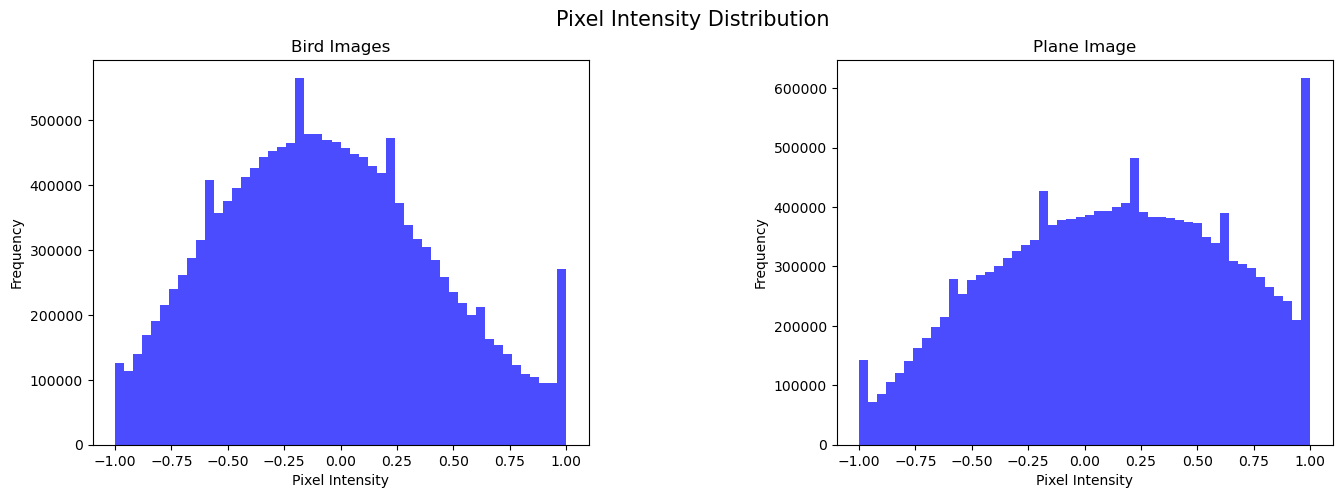

In [15]:
# Total histogram for each set
fig1 = plt.figure(figsize=(16,5))

gs = fig1.add_gridspec(1,2)

ax1 = fig1.add_subplot(gs[0, 0])
ax1.hist(bird_images.flatten(), bins=50, color='blue', alpha=0.7)
ax1.set_title('Bird Images')
ax1.set_xlabel('Pixel Intensity')
ax1.set_ylabel('Frequency')

ax2 = fig1.add_subplot(gs[0, 1])
ax2.hist(plane_images.flatten(), bins=50, color='blue', alpha=0.7)
test = 12
ax2.set_title('Plane Image')
ax2.set_xlabel('Pixel Intensity')
ax2.set_ylabel('Frequency')
    
fig1.suptitle('Pixel Intensity Distribution', fontsize=15)

plt.subplots_adjust(wspace=0.5, hspace=0.5) # Change the values as needed
plt.show()

Taking the overall pixel value distributions for the two classes, we observe a wider range of colours in the plane images, yet a higher peak of certain colours in the bird images. Stark differences like this between these distributions give us confidence that the model may be able to use this as a significant feature to distinguish the bird and plane images from each other. Furthermore, while the distribution here is relatively uniform for each set, we can see outliers in certain pixel value frequencies for both. In particular, the pixel value 1 is the normalised value of the colour white (originally 255) and represents real-world images that the model could recieve as getting pictures of birds/planes with a heavy white prescence (e.g. it's plausible that many images of a white plane flying with white clouds in the background could explain the spike in the plane pixel distribution). Nonetheless, the visual differences between the distributions reinforce that there should be sufficient variety for the model recognise birds and planes under a range of conditions.

## Creating a Simple CNN for Image Classification

### Basics of Convolutional Neural Networks (CNNs)

For image classification tasks, standard neural networks don't scale well as image size increases and aren't very accurate<sup>[5]</sup>. As such, we will be using a CNN to classify our images. We can begin by constructing a SimpleCNN for image classification, and to do that we need to know the structure of CNNs. Like most deep neural networks, we must initialise the layers, which we can do with the '__init__' function. We must also use the forwards function to define the forward pass of the network, which is what takes an input tensor and returns an output tensor after feeding forward through the network.<sup>[5]</sup>
In this model, we will be using the following layers:

>  - **The convolutional layer**: In this layer, a set of filters (kernels) is applied to the input, to extract any meaningful patterns or features of the data and create a 'feature map' from this. It has several arguments, including the kernel size which denotes the size of the convolutional filter applied, and the stride which relates to how many pixels that filter steps across the input image at a time. It also has in_channels which indicates how many feature map inputs it takes, and an out_channel for the output tensor. To calculate the size of our output tensor (without padding) we can use the following formula -> Output size of convolution = [(width or height of image) - (size of kernel)] / (stride) + 1. E.g., 32-5/1 + 1 = 28. 
>  - **The pooling layer**: In this layer, the feature maps are 'pooled' reducing their dimensions, leading to fewer parameters. This is to condense the information within the feature maps, thus reducing the amount of computation that the network performs. It also has a kernel size and stride like the convolutional layer. 
>  - **The fully connected layer**: As the name suggests, all neurons in a fully connected layer are connected to all activations in the previous layer. In CNNs, these layers often come after convolutional and pooling layers. The amount of neurons is determined by the amount of outputs, with each neuron consisting of a weight and a bias.

We also need to consider the 'forward' function, which is where we actually walk through the network, taking normalised tensors as inputs and returning a probability between 0 and 1 as an output. In our case, a probability of 1 indicates a certain bird prediction and a probability of 0 indicates a certain plane prediction. If an output returns 0.55 the network predicts a 55% chance of the image being a bird. When designing the forward pass on the network, we must also consider the activation functions, on top of the layers it's running through. The purpose of an activation function is to introduce non-linearity into the outputs of our neurons, as in the real world data is rarely linear and cannot be accurately modelled by a straight line. To do this it decides whether or not the neuron should be activated based on the weighted sum and bias. Here, we will be using the popular 'ReLU' and 'Sigmoid' activation functions in the forward pass of the model.<sup>[6]</sup>.
> - The **ReLU**, or Rectified Linear Unit function, performs the operation max(0,x), where x is the output tensor of the layer, giving us the output x if positive, and 0 otherwise. Due to its simplistic nature, this function has the benefit of being less computationally expensive than other activation functions and by extension, it results in efficient and faster training. It is bound by the range [0, x], where x>0.
> - The **Sigmoid** function is slightly more complex than the ReLU computationally. It performs the operation 1/(1 + e<sup>-x</sup>) and results in an S shaped graph between [0,1]. This is used in the final layer since the output of Sigmoid is bound to the range [0, 1] which matches the necessary range for probabilities.

We can see how a feature map size of 4x4 is reduced to a 2x2 by applying a kernel of size 3x3 with a stride of 2 below<sup>[7]</sup>:\
![Feature map.](https://miro.medium.com/v2/resize:fit:1400/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif) 

### Creating Dataloaders

Next we must create dataloaders, so we can have an iterable over our dataset:<sup>[3]</sup>

In [35]:
# here batch_size = 64 means we feed the models images in batches of 64 per iteration.
trainloader = DataLoader(trainset_filtered, batch_size=64, shuffle=True, num_workers=4)
testloader = DataLoader(testset_filtered, batch_size=64, shuffle=False, num_workers=4)

We shuffle the data in our training dataset. This is to make sure that the model doesn't learn anything from the order of images input. This isn't necessary with our testing dataset however, so we can leave this false. 
Num_workers relates to the number of seperate workers that will load the data in parallel. While a high number of workers may speed up performance, it may also increase memory utilisation so its good to strike a balance.
We are also using a batch size of 64. On one hand, a smaller batch size can be good for training speed, but risks underfitting to the data and slower learning. On the other hand, a batch size too high risks overfitting to features in the dataset.

### Defining the Simple CNN Architecture

We can now define our simple model, based on the discussion we had before.<sup>[8]</sup> When first tackling this problem I found them to be well explained by 'Codemy' on youtube, which I used as a reference point when creating this model<sup>[19]</sup>.

In [36]:
class SimpleCNN(nn.Module): # nn.Module is the base class for all neural network modules in PyTorch
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Define a convolutional layer:
        # Since each image is 32x32 pixels with 3 channels for RGB, applying 5x5 convolutional kernel with 1 stride produces 6 output channels of 28x28 feature maps (32-5/1 + 1 = 28).
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5,stride=1,padding=0)
        
        # Define a max pooling layer:
        # Max Pooling layer with a 2x2 kernel and a stride of 2. This will reduce the spatial dimensions of the output from the first convolutional layer by half.
        # Turning 6 output channels of 28x28 into 6 output channels of 14x14.
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        # In effect, the convolutional and max pooling layers have reduced the dimensions of the input images from 3 channels of 32x32 to 6 channels of 14x14.
        
        # Define a fully connected (linear) output layer:
        # Since this layer is linear, the input size must be 'flattened' from a 3D feature map to a 1D vector.
        # The size of this vector is 14*14*6 = 1176, calculated by multiplying the spatial dimensions of the feature map (14x14) with the number of channels (6).
        # The output of this layer is a logit (e.g. 1 or 0) denoting the class prediction of the model (e.g. bird or plane). 
        # The output of this layer is a logit, which is a raw prediction or 'score' given to the input by the model. Later this becomes a probability we can use for binary classification.
        self.fc = nn.Linear(in_features=(14 * 14 * 6), out_features=1)

    # Define the forward pass for the network:
    def forward(self, x):
        # Apply ReLU activation function on the output tensor of the first convolutional layer.
        x = F.relu(self.conv1(x))
        # Apply max pooling to the resultant tensor.
        x = self.pool(x)
        # Flatten the tensor for the fully connected layer.
        x = x.view(-1, 14*14*6)
        # Apply sigmoid activation function to the output tensor of the fully connected layer to get output probabilities in the range [0, 1].
        x = torch.sigmoid(self.fc(x))
        x = torch.squeeze(x) # Here squeeze() is used on the output tensor to remove extra unnecessary dimensions, such as the batch size, in order to focus further analysis on the binary classification output.
        return x

Simple_CNN = SimpleCNN().to(device) #Instantiate the model and offload it to GPU if available
Simple_CNN

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=1, bias=True)
)

- **in_channels** = the number of channels in the input feature map.
- **out_channels**: the number of output channels after passing through the layer.
- **kernel_size**: the dimensions of the kernel.
- **stride**: the stride of the kernel applied over the input feature map.
- **padding**: padding is used to maintain the spatial features of the input feature map (which would likely be reduced by the convolution). This is particularly useful for preserving information at the edges of the feature map. 

### Defining the Loss Function and Optimizer

The loss function is what we use to calculate the error, quantifying the difference between the predictions by the model and the ground truth. Loss is usually a non-negative value. The more positive loss a model generates from its predictions, the more the model is 'penalised' during the training process with updates to its parameters. In this way, observing the loss of the model helps us measure performance, while also indicating the direction to improve in. For general image classification, you will likely want to use Cross-Entropy classification, however in our case, as we only have 2 sets of images, we can use Binary Cross-Entropy: 
$$
L_{BCE} = -\frac{1}{n} \sum_{i=1}^{n} \left(t_i \cdot log(\hat{t}_i) + (1 - t_i) \cdot log(1 - \hat{t}_i)\right)
$$
The above formula gives us Binary Cross Entropy (BCE) loss across all data samples (n). In this formula, 't' is the truth value, i.e. the actual label, while 'p' is our predicted probability given by the model, that a particular datapoint has a label (e.g. of 1 or 0). To break it down, we can take an example of a single data point and explain it as follows. \
Suppose a data point has an actual label of 1, classified as a bird. Reducing this formula to an individual data point, we can see that the BCE loss on this datapoint is calculated as a function of the probability (p) our model has assigned to the label being a 1 and of the actual label. For example, if the actual label is 1, the function becomes:
$$
l = -(1*log(p) + (1-1)log(1-p)) = -(1*log(p))
$$
In this situation, the loss grows as p deviates from 1 (as the model puts more weight on the image being a plane rather than a bird), indicating that the model is penalised for assigning a probability that differs from the ground truth. By aggregating this loss over an entire batch, using the first formula, we can find the average loss which can then be used to update the model's parameters and optimise the loss<sup>[9]</sup>.

Next we must define an optimizer for our model. The role of an optimizer is to find the optimal model parameters. Optimizers dictate the learning rate of the model, which is a hyperparameter that controls by how much model parameters are adjusted during the training process; i.e., a lower initial learning rate means smaller updates in parameters. The choice of learning rate is important for the stability of the training process and the speed of convergence. We will be using the Adam optimizer, which is a gradient-based optimizer that adjusts the learning rate for each parameter based on the respective first-order gradients of the loss, leading to faster convergence and improved network performance<sup>[10]</sup>. There are many different available optimizers though, so it can be a matter of trial and error to find the most effective one.

In [18]:
# Define the loss function as Binary Cross Entropy Loss.
loss_fn = nn.BCELoss()

# Define the optimizer as Adam. This is a gradient-based optimizer which adjusts the learning rate for each parameter based on the respective first-order gradients of the loss.
# Simple_CNN.parameters(): extracts all the trainable parameters (e.g. weights and biases between nodes) of our SimpleCNN model.
# lr=0.001: Sets the initial learning rate of the model to 0.005. The learning rate is hyperparameter controls how much model parameters are adjusted during the training process; i.e., a lower initial learning rate means smaller updates in parameters.
# The choice of learning rate is important for the stability of the training process and the speed of convergence.
optimizer = optim.Adam(Simple_CNN.parameters(), lr=0.005)

### Training the Image Classifier

We now have our basic image classifier model and must train it. When training our dataset we must consider how many 'epochs' we want. An epoch in machine learning is defined as one complete pass of the training dataset, and in large datasets you may be able to use 1 epoch (or even less) resulting in 1 loop over the data. As we use more epochs while training, our training data should get closer to the expected output, however using too many epochs can cause overfitting. This is where the model learns the training data too well and can perform well on this data but poorly on new, unseen data. We will use 20 epochs as it is more than sufficient for this task, without overtraining it, though you can set this number to what you want.

In [19]:
num_epochs = 20

Now we want to define our training loop.<sup>[5]</sup> This is where we essentially feed the model our data for every epoch through the forward pass function of our model and, based on our output (the prediction on the data), the weights and biases of our model are adjusted using backpropagation (the backward pass). To do this we can start by initialising an array to keep track of our loss over time, before defining a loop for all of our epochs. Within this loop, we can initialise an integer to keep track of our loss over our current epoch. We can then iterate over the trainloader dataset, and begin training for each batch. To begin, we first move the data to our Cuda-enabled GPU format, if available, as it speeds up training times. We must also zero the gradients on our optimizer in each iteration to prevent the accumulation of gradients from previous batches. Next, we can feed our current batch of 64 images to our Simple_CNN, which will perform the forward pass on the batch and return a prediction. Using this output prediction, we calculate the BCE loss between the outputs and true labels for the batch, then backpropagate through the network, calculating the gradient of the loss with respect to all our model parameters. Finally, we can use the 'step' function of the optimizer to update our model parameters (weights and biases) with the aim of minimising loss. You can, optionally, add an increment to running_loss if you want to keep track of it, as we have done so here. Similarly to the defining of our model, I found the codemy videos on training CNNs very useful for a detailed explanation of how this works, which I recommend referencing if you are having difficulty with any of this section. <sup>[20]</sup>

In [20]:
def train_model(cnn, dataloader, loss_fn, optimizer, total_loss):
    for epoch in range(num_epochs): # Iterate over all epochs.
        running_loss = 0.0  # Initialize running loss for this epoch.
        for data in dataloader: # Iterate over the data in the dataloader.
            inputs, labels = data # Unpack the data. 'inputs' are the images, 'labels' are the corresponding binary labels.
            inputs, labels = inputs.cuda(), labels.cuda()
            labels = labels.float() # Convert labels to float type to match the output type of the CNN (which is likely float due to sigmoid activation in the last layer).

            # Zero the gradients before running the backward pass.
            optimizer.zero_grad()

            # Forward pass: input data to model to compute the predicted labels.
            outputs = cnn(inputs)

            # Calculates the binary cross entropy loss between the predicted labels (outputs) and the true labels.
            loss = loss_fn(outputs, labels)

            # Backward pass: compute gradient of the loss with respect to model parameters.
            loss.backward()

            # Perform a single optimisation step (parameter update).
            optimizer.step()

            # Accumulate the loss for the epoch.
            running_loss += loss.item()

        # Calculate the average loss for this epoch.
        loss_per_epoch = running_loss / len(dataloader)
        # Append the average loss for this epoch to the total_loss list for later analysis or plotting.
        total_loss.append(loss_per_epoch)
        # Output the average loss
        print(f"Average loss over epoch {epoch + 1}: {round(loss_per_epoch, 3)}")      

Now that we have defined our training loop, we want to run it.

In [21]:
# Initialise an empty list to store the loss after each epoch.
simple_total_loss = []

# Get the time at the beginning of the training loop
start_time = time.time()

# Call the train_model function to start training the model. 
train_model(cnn=Simple_CNN, dataloader=trainloader, loss_fn=loss_fn, optimizer=optimizer, total_loss=simple_total_loss)

# After training, compute the total training time by subtracting the start time from the current time.
simple_training_time = time.time() - start_time

# Print out the total training time in seconds.
print(f"Training runtime: {simple_training_time} seconds")

Average loss over epoch 1: 0.447
Average loss over epoch 2: 0.374
Average loss over epoch 3: 0.351
Average loss over epoch 4: 0.333
Average loss over epoch 5: 0.321
Average loss over epoch 6: 0.314
Average loss over epoch 7: 0.3
Average loss over epoch 8: 0.305
Average loss over epoch 9: 0.295
Average loss over epoch 10: 0.287
Average loss over epoch 11: 0.29
Average loss over epoch 12: 0.283
Average loss over epoch 13: 0.28
Average loss over epoch 14: 0.271
Average loss over epoch 15: 0.267
Average loss over epoch 16: 0.267
Average loss over epoch 17: 0.259
Average loss over epoch 18: 0.25
Average loss over epoch 19: 0.26
Average loss over epoch 20: 0.254
Training runtime: 243.3865885734558 seconds


As we can see, we start with an initially high loss per epoch, at around 0.447, though this drops to almost half during our runtime. While this is certainly an improvement compared to the beginning, this loss is still relatively high and we could improve upon this.

### Evaluating Model Accuracy and Loss

We can now visualise how our network performed over the course of our epochs, using the total loss calculated in previous steps.

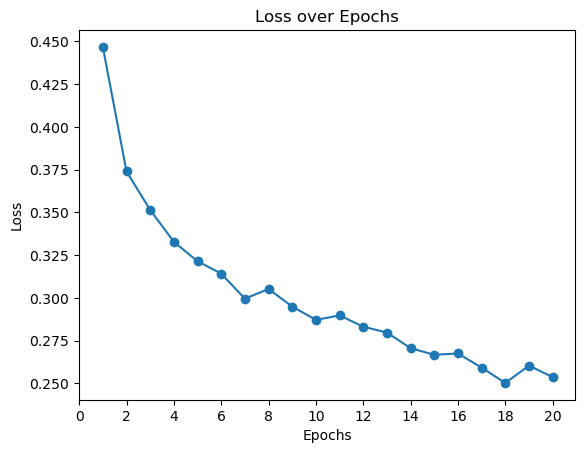

In [22]:
plt.plot(range(1,num_epochs+1), simple_total_loss, marker="o", linestyle="-")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(0,num_epochs+1,2))
plt.show()

As we can see, when our training started, our average loss was close to 0.5, which makes sense as the network was predicting values without knowledge of the network, essentially making random guesses. Throughout each epoch, and through training, this loss was greatly reduced, to around 0.27. This loss value is still relatively high and can be optimised with a better model.

Next we can check the accuracy of our model using our test set to check how well it works on new, fresh data.

In [23]:
def compare_accuracy(model, dataloader):
    if(torch.cuda.is_available()):
        model.cuda()
    total = 0
    correct = 0
    for data in dataloader:
        (inputs, labels) = data
        if(torch.cuda.is_available()):
             inputs, labels = inputs.cuda(), labels.cuda() 
        labels = labels.float() 
        outputs = model(inputs) #Run batch through model and recieve outputs
        predicted = outputs >= 0.5 #If probability >= 0.5, predict it as a bird. Otherwise predict it as a plane.
        total += labels.size(0)
        correct += (predicted.float() == labels).sum().item() #Check which predictions match the labels, and increment correct for every correct prediction
    return 100*correct/total

simple_accuracy_train = compare_accuracy(Simple_CNN, trainloader)
simple_accuracy_test = compare_accuracy(Simple_CNN, testloader)

print(f"Accuracy on Training Set: {simple_accuracy_train}%") #Calculate the accuracy by dividing correct predictions, by total predictions
print(f"Accuracy on Test Set: {simple_accuracy_test}%") #Calculate the accuracy by dividing correct predictions, by total predictions

Accuracy on Training Set: 88.66%
Accuracy on Test Set: 84.0%


As we can see, we have a slightly higher accuracy on our training set, indicating a moderate amount of overfitting, but otherwise, we have a relatively accuracy model considering the size of the network. We should be able to improve this with a more complex model, which we can attempt to create. Overfitting is behaviour in machine learning, where our model gives accurate predictions for the training data it has been tested on, but not for the testing data. It is pretty hard/impossible to completely avoid a small amount of overfitting, when training models on a large amount of data, however, you can take measures to avoid this by taking measures such as adding dropout layers (covered later), using more data and cross-validation (which will not be covered in this guide). Underfitting is the opposite of this issue and is when the model is unable to capture a relationship between the outputs and the data. This means that the model will not be accurate on the training data or the testing data and can occur when the model is too simple, not enough training time or a range of other causes.

## Hyperparameter Optimisation: Adding Complexity to our Image Classifier

Now we can construct a more complex model based on our previous model to try and achieve a better accuracy. To do this, we have increased the amount of layers being used, along with changing the properties of pre-existing layers in order to optimise our model. We have also added 2 new layers to this model, in an attempt to improve the accuracy:
> The dropout layer. This layer provides a probability which determines whether a node will be dropped out in an attempt to negate overfitting. I have provided them here with a 35% probability. \
> The batch normalisation layer. The batch normalisation normalises inputs from the previous layer, standardising the input which improves mitigates the problem of vanishing or exploding gradients.

### Experimenting with Different Architectures

In [24]:
class ComplexCNN(nn.Module):
    def __init__(self):
        super(ComplexCNN, self).__init__()
        # 3 input channels (RGB), 16 outputs, 5x5 convolution 
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1) 
        self.batch1 = nn.BatchNorm2d(32) #Batch norm layer doesn't change size of tensor
        self.conv2 = nn.Conv2d(32,64,3,1,1)
        self.batch2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64,128,3,1,1)
        self.batch3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*8*8, 256) 
        self.dropout1 = nn.Dropout(p = 0.35) 
        self.fc2 = nn.Linear(256, 128) 
        self.dropout2 = nn.Dropout(p = 0.35)
        
        self.fc3 = nn.Linear(128,1) # 1 output, for binary classification (Bird or Airplane).

    #Conduct forward pass on model    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.batch3(x)
        x = self.pool2(x)
        x = torch.flatten(x,1) # Total number of elements in tensor
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x)) # Apply sigmoid activation to the output layer for binary classification
        x = torch.squeeze(x) #Squeezes the torch to our desired output size
        #print(x)
        return x


Complex_CNN = ComplexCNN().to(device) 
Complex_CNN



ComplexCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (dropout1): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

### Adjusting Learning Rates and Other Parameters

We can now train the model using the same function we defined for the simple CNN. 
Along with the changes made to the network architecture, I have adusted the learning rate from 0.005 to 0.001

In [25]:
complex_total_loss = [] #Counts loss
start_time = time.time() #Get the time at the beginning of the training loop
optimizer = optim.Adam(Complex_CNN.parameters(), lr=0.001)
train_model(cnn=Complex_CNN, dataloader=trainloader, loss_fn=loss_fn, optimizer=optimizer,total_loss=complex_total_loss)
complex_training_time = time.time() - start_time
print(f"Training runtime: {complex_training_time} seconds")

Average loss over epoch 1: 0.401
Average loss over epoch 2: 0.298
Average loss over epoch 3: 0.242
Average loss over epoch 4: 0.206
Average loss over epoch 5: 0.168
Average loss over epoch 6: 0.132
Average loss over epoch 7: 0.105
Average loss over epoch 8: 0.082
Average loss over epoch 9: 0.063
Average loss over epoch 10: 0.05
Average loss over epoch 11: 0.056
Average loss over epoch 12: 0.036
Average loss over epoch 13: 0.031
Average loss over epoch 14: 0.028
Average loss over epoch 15: 0.033
Average loss over epoch 16: 0.022
Average loss over epoch 17: 0.016
Average loss over epoch 18: 0.019
Average loss over epoch 19: 0.022
Average loss over epoch 20: 0.024
Training runtime: 251.11980557441711 seconds


The training time of our new, complex model is only a few seconds slower than our simple model, despite being a lot more complicated. This is because we are bottlenecked iterating over our trainloader and our GPU is running the model fast enough to make the time difference nearly negligible. These results may however vary on different hardware.

### Evaluating Model Performance

We can now evaluate the accuracy of our new Complex model and check for overfitting like we did in our simple model.

In [26]:
complex_accuracy_train = compare_accuracy(Complex_CNN, trainloader)
complex_accuracy_test = compare_accuracy(Complex_CNN, testloader)

print(f"Accuracy on Training Set: {complex_accuracy_train}%    Improvement over Simple Model: {complex_accuracy_train-simple_accuracy_train:.2f}%") #Calculate the accuracy by dividing correct predictions, by total predictions
print(f"Accuracy on Test Set: {complex_accuracy_test}%    Improvement over Simple Model: {complex_accuracy_test-simple_accuracy_test:.2f}%") #Calculate the accuracy by dividing correct predictions, by total predictions

Accuracy on Training Set: 99.63%    Improvement over Simple Model: 10.97%
Accuracy on Test Set: 92.2%    Improvement over Simple Model: 8.20%


The accuracy of this new complex model is better than our simple model by a fair margin on the testing set, but it is leagues ahead on the training set. While this model's performance is good, the training set accuracy indicates moderate overfitting has occurred and while this may be possible to somewhat correct with tweaking, after tweaking values this was the best performance I was able to obtain through adjusting the various hyperparameters.

We can also view the loss of our new complex model across epochs and compare it to out simple model:

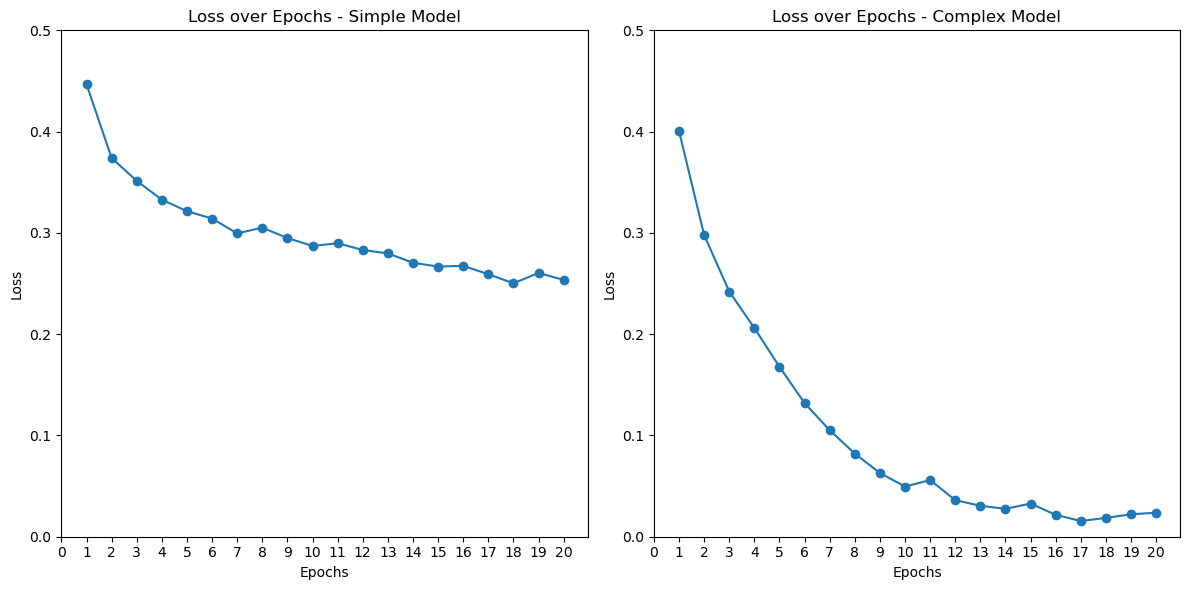

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(range(1, num_epochs + 1), simple_total_loss, marker="o", linestyle="-")
ax[0].set_title("Loss over Epochs - Simple Model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_xticks(range(0, num_epochs + 1))
ax[0].set_ylim(0, 0.5)

ax[1].plot(range(1, num_epochs + 1), complex_total_loss, marker="o", linestyle="-")
ax[1].set_title("Loss over Epochs - Complex Model")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].set_xticks(range(0, num_epochs + 1))
ax[1].set_ylim(0, 0.5)

plt.tight_layout()
plt.show()

As we can see, we have a substantially lower final loss in our complex model, indicating that it is more reliable and optimal than our simple model. Not only this, but it has a far steeper downtrend than the simple model, so is learning/optimising faster per epoch than the simple model, despite the lower learning rate. Therefore, in terms of aiming for lower loss, the complex model does far better than the simple model in this area.

To compare both our previous models, we will sample 5 random images from the dataset, and compare the accuracy of predictions from either model.

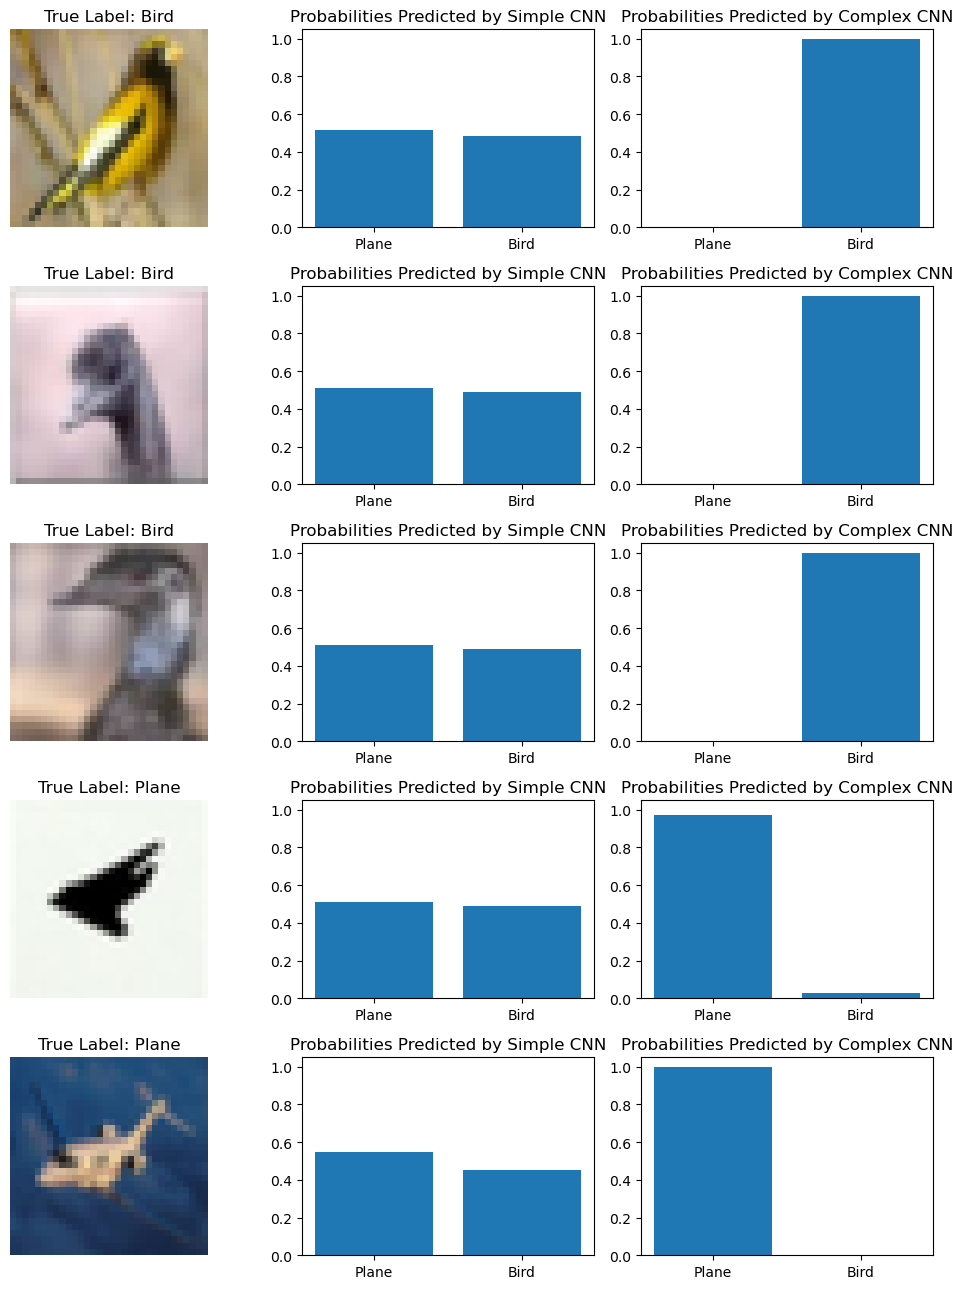

In [37]:
dataiter = iter(testloader)
images, labels = next(dataiter)
indices = np.random.choice(np.arange(len(images)), 5, replace=False)
images, labels = images[indices], labels[indices]
Simple_CNN = Simple_CNN.cpu() #Move back to CPU if on GPU
Complex_CNN = Complex_CNN.cpu()
Simple_CNN.eval()
Complex_CNN.eval()
with torch.no_grad():
    simple_outputs = Simple_CNN(images)
    complex_outputs = Complex_CNN(images)

fig, axes = plt.subplots(5, 3, figsize=(10, 13))  # Adjusted for 5 images, each with 2 subplots

for i, (image, label, simple_probability, complex_probability) in enumerate(zip(images, labels, simple_outputs, complex_outputs)):
    image = image / 2 + 0.5
    npimage = image.numpy()
    axes[i, 0].imshow(np.transpose(npimage, (1, 2, 0)))  # Directly show the image in the subplot
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'True Label: {"Bird" if label.item()==1 else "Plane"}')
    
    axes[i, 1].bar(['Plane', 'Bird'], [1-simple_probability.item(), simple_probability.item()])
    axes[i, 1].set_ylim(0, 1.05)
    axes[i, 1].set_title('Probabilities Predicted by Simple CNN')

    axes[i, 2].bar(['Plane', 'Bird'], [1-complex_probability.item(), complex_probability.item()])
    axes[i, 2].set_ylim(0, 1.05)
    axes[i, 2].set_title('Probabilities Predicted by Complex CNN')

plt.tight_layout()
plt.show()

# source [18] https://github.com/sachinruk/deepschool.io/blob/master/DL-Keras_Tensorflow/Lesson%2012%20-%20CIFAR10%20CNN%20-%20Solutions.ipynb

Here you can see that the complex model is often more certain with its predictions than the Simple CNN, sometimes to a fairly substantial degree. When we consider all the improvements we are seeing with this model, along with only a fractional increase in training time, we can conclude that on this hardware configuration, the complex model is worth the step-up from the single model, as it provides far better results for the extra computation involved. This may vary by different hardware so may not be the same for you.

### Hyperparameter Tuning Results

Throughout the creation of the complex model, I adjusted various hyperparameters, such as the number of epochs, layers etc. The results for each tweak gave me slightly different results:
> - Adjusting the number of epochs seemed to have a fairly significant effect on the performance of the model and how long it took to run. I started with 5 epochs, where the model was still relatively accurate, and scaled it up to 40. When on the lower end, though the model trained far faster, it did not have the same accuracy or a loss as low as the higher epoch variants, and as I scaled up too high the training time was greatly increased with negligible improvements to accuracy or loss. I went with 20 as it was a good middle ground between reasonable training times and good results. It is also worth noting that increasing the epochs too high may lead to overfitting, and actually reduce the accuracy of your model on new data.
> - Learning rate was also adjusted, as I set the complex model learning rate as high as 0.01 and as low as 0.0001. Here I noticed that while the learning rate was lower, the training took slightly longer, however, this time difference was relatively low, likely due to the bottleneck iterating through our trainloader. Moving the learning rate too low, at 0.0001 seemed to negatively impact our test set accuracy, while slightly improving our training set accuracy, implying some level of overfitting. In the end, I determined that 0.001 provided the best accuracy of all the values I tested.
> - Increasing the number of layers, including introducing new layers such as the batch normalisation and dropout layers, had a noticeable effect on the outcome of the model results. As I was happy with the training times and with the accuracy provided with this model, I did not add any more layers, but doing so may or may not prove beneficial when training a model, so it is worth experimenting and seeing what gives you your desired outcome.
> - Finally, changing the properties of our layers such as kernel size had an effect on our model performance as setting the kernel too large resulted in loss of accuracy, likely because detail from the images was lost. Padding and stride would also affect this, though upon modifying these values, I did not notice a significant enough change in our model loss or accuracy to confirm whether this was related to these features or not. Different models identify different data, adjusting these values may result in bigger changes.


## Applying our Optimised Image Classification Model in a GAN

### Introduction to Generative Adversarial Networks

Now that we have gone over the basics of CNN's we can apply our knowledge to the creation of a GAN. This stands for 'Generative Adversarial Model' and is used to create images. In our example, we will target creating images of birds. A GAN has 2 main components, a generator and a discriminator.
we will define a GAN model to generate pictures of birds. GAN standards for 'Generative Adversarial Network' and has 2 main components: a generator and a discriminator. The goal of the generator is to, you guessed it, generate images, which it does from an input of random noise that it receives. The goal of the discriminator is to determine if an image it receives is real or fake, and is really just a binary image classifier of real and fake images<sup>[12]</sup>.

In [29]:
trainset_filtered_birds = Subset(trainset_filtered, bird_indices)
bird_trainloader = DataLoader(trainset_filtered_birds, batch_size=64, shuffle=False, num_workers=4)

### Defining the Generator Model

First, we must define our Generator. Similarly to a CNN, it can have convolutional and batch norm layers, but here we also want to end on a convolutional layer so we get a feature map as an output. As our images are 32x32 and RGB they have 3 channels, and as such we want our fake images to be the same size, so we will aim for this when defining the model. We can also experiment with the hyperbolic tangent (tanh) function, another activation function that often works better than the sigmoid, though is slightly more complicated (and is essentially a mathematically shifted sigmoid). The formula is as follows: (2/((1+e)<sup>-2x</sup>) - 1)<sup>[11]</sup> We choose this as the output activation for generating images because it outputs values in the range [-1,1] - the range we normalised our pixel values to. Having the output of the generator directly compatible with the normalised pixel value range makes it easier to train the network and achieve stable convergence. A limitation of this activation function is that it can suffer from the vanishing gradient problem where the function plateaus for inputs in certain regions.

In [30]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Transposed convolutional layer to upscale from noise vector to feature map.
        # Input noise vector of length 100, output feature map of 512 channels, 4x4 spatial size.
        self.tconv1 = nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False)
        # Batch normalization to stabilize learning by normalizing the input to have zero mean and unit variance.
        self.batchnorm1 = nn.BatchNorm2d(512)

        # Further upscale feature map to 256 channels, 8x8 spatial size.
        self.tconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(256)

        # Upscale feature map to 128 channels, 16x16 spatial size.
        self.tconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(128)

        # Upscale feature map to 64 channels, 32x32 spatial size.
        self.tconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm4 = nn.BatchNorm2d(64)

        # Final transposed convolution to produce an RGB image of 32x32 pixels from the 64 channel feature map.
        self.tconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.tconv1(x))) 
        x = F.relu(self.batchnorm2(self.tconv2(x))) 
        x = F.relu(self.batchnorm3(self.tconv3(x)))  
        x = F.relu(self.batchnorm4(self.tconv4(x)))  
        x = torch.tanh(self.tconv5(x))
        return x

# Instantiate the Generator model and move it to the appropriate device (GPU or CPU).
generator = Generator().to(device)
generator

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

### Defining the Discriminator Model

Next, we must define the discriminator model. Originally, the plan was to utilise the exact same structure of the Complex_CNN that had proven effective during image classification, however as it turns out, using the same CNN classifier architecture overpowered the generator, weakening its ability to generate any convincing images. Like Kryptonite to Superman, the unbalanced discriminator weakened the generators ability to fool it, leading the GAN to display no signs of convergence during training.<sup>[13]</sup>. As such, the discriminator model has been intentionally weakened to adapt it to the generator, removing the third convolutional and batch layers in the Complex_CNN along with the second pooling layer. After updating the parameters of the model to account for this, the discriminator became more balanced to the generator as shown by the success in generating more realistic images after sufficient training.

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1) #32-3+2/1 + 1 = 32
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,3,1,1)
        self.batch2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*16*16, 256)
        self.dropout1 = nn.Dropout(p = 0.35) 
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(p = 0.35)
        self.fc3 = nn.Linear(128,1)     

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.pool1(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x)) 
        x = torch.squeeze(x) 
        return x
discriminator = Discriminator().to(device)
discriminator

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (dropout1): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.35, inplace=False)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

### Training the GAN

Training the GAN involves an adversarial learning process, whereby the generator and discriminator behave as adversaries, playing a minimax game against each other. In one corner, the discriminator is acting as a binary classifier and attempts to classify images as real or fake, ideally catching the generator's fake images. In the opposite corner, the generator is attempting to generate fake images that appear real enough to fool the discriminator. The consequence of the adversarial learning during the training process is that the generator can learn how to mimic real images of birds and apply successive transformations to random noise vectors to create unique and realistic images of birds.

As this is a complex process and is far from simple image classification, we will be using 200 epochs to make sure the model has had sufficient time to train. We are also adjusting the momentum here, a hyperparameter we didn't touch in the earlier model. It is an extension of gradient descent and it builds 'inertia' when moving in a particular direction, to overcome the problem of plateauing with local minima. Here we also define the same Adam optimizer as before for both our generator and our discriminator. This means we also want to take multiple loss values into account, rather than just 1, so we define them here. <sup>[14]</sup>

In [32]:
# Define the loss function for training the GAN.
loss_fn = nn.BCELoss()
# Define the number of epochs.
gan_num_epochs = 200
# Define the optimizer for the Generator with a low learning rate and betas for momentum.
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# Define the optimizer for the Discriminator with the same settings as the Generator.
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Labels for real and fake images.
fake_label = 0
real_label = 1

# Initialise empy lists to track losses and confidence levels.
loss_disc_values = []
loss_gen_values = [] 
disc_confidence_values = [] 
disc_gen_confidence_before_values = []
disc_gen_confidence_after_values = [] 

# Create an empty list to store images generated by the Generator for later visualisation.
images = []
# Generating a fixed noise vector for visualising the progression of generated images.
test_noise_vector = torch.randn(64, 100, 1, 1, device=device)

There are three training phases involved in each loop on the dataset of birds for the GAN:
1. **Train the discriminator on real images**: Here we essentially follow the standard training process for a classifier, using a batch of real (and later fake) images, without stepping through the optimizer.
2. **Train the discriminator on fake images from the generator**: By generating a random noise vector as input, we run the noise vector through the generator to produce a batch of fake images before passing these through our discriminator to obtain a loss value to optimise the generator's output.
3. **Update the generator based on the output of the discriminator from step 2.**: after calculating the loss for our fake images, we have done the training of our discriminator and can update it with our optimizer. Our last step is updating the generator's parameters using the same loss from the discriminator on the batch of fake images.

After doing this for every datapoint over all our epochs, and assuming effective adversarial learning, we produce a batch of transformed noise vectors which are ideally somewhat recognisable as birds.<sup>[14]</sup>.

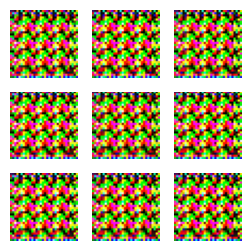

Epoch 1/200
Discriminator Loss: 0.022422004491090775
Generator Loss: 6.6749267578125
Discriminator Confidence (Real): 0.9813034534454346
Discriminator Confidence (Fake): Before Generator Update: 0.0029509924352169037, After Generator Update: 0.002274785889312625



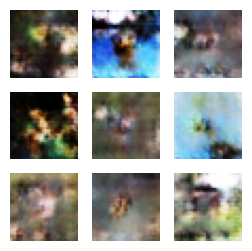

Epoch 40/200
Discriminator Loss: 0.01222056895494461
Generator Loss: 8.732475280761719
Discriminator Confidence (Real): 0.9998297095298767
Discriminator Confidence (Fake): Before Generator Update: 0.011898297816514969, After Generator Update: 0.0037339837290346622



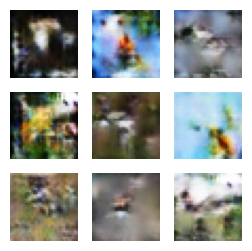

Epoch 80/200
Discriminator Loss: 0.010510619729757309
Generator Loss: 6.406128406524658
Discriminator Confidence (Real): 0.9962024688720703
Discriminator Confidence (Fake): Before Generator Update: 0.006611090153455734, After Generator Update: 0.009516682475805283



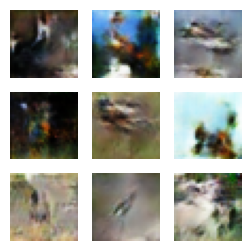

Epoch 120/200
Discriminator Loss: 0.032535403966903687
Generator Loss: 7.724116802215576
Discriminator Confidence (Real): 0.9742928147315979
Discriminator Confidence (Fake): Before Generator Update: 0.004235598258674145, After Generator Update: 0.00453414348885417



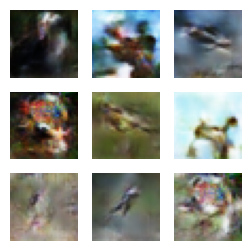

Epoch 160/200
Discriminator Loss: 0.007134818471968174
Generator Loss: 5.989997386932373
Discriminator Confidence (Real): 0.9989023208618164
Discriminator Confidence (Fake): Before Generator Update: 0.005935456603765488, After Generator Update: 0.01112957764416933



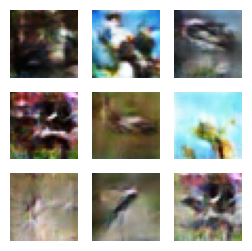

Epoch 200/200
Discriminator Loss: 0.0010649306932464242
Generator Loss: 7.8115057945251465
Discriminator Confidence (Real): 0.9999964237213135
Discriminator Confidence (Fake): Before Generator Update: 0.0010598727967590094, After Generator Update: 0.0019016113365069032

Training runtime: 2847.5476779937744 seconds


In [33]:
for epoch in range(gan_num_epochs):
    for data in bird_trainloader:
        # Train the Discriminator on real images:
        real_data = data[0].to(device) # Load real images to the device.
        discriminator.zero_grad()
        # Prepare labels for real images.
        images_and_labels = torch.full((real_data.size(0),),real_label,dtype=torch.float, device=device)
        # Conduct forward pass on the Discriminator using real images as input.
        outputs = discriminator(real_data).view(-1)
        # Calculate the Discriminator's loss for real image recognition.
        real_discrimiator_loss = loss_fn(outputs, images_and_labels)
        # Conduct backward pass on the Discriminator to calculate the gradients of the loss on real images with respect to Discriminator's parameters.
        real_discrimiator_loss.backward()
        # Calculate the Discriminator's confidence in recognising real images.
        disc_confidence = outputs.mean().item()

        # Train the Discriminator with fake images:
        # Generate a random noise vector to input into the Generator.
        noise = torch.randn(real_data.size(0),100,1,1,device=device) #Generate random noise vectors of the same batch size as our real_data, with 100 size
        # Generate fake images from the noise.
        fake_images = generator(noise)
        # Label fake images as fake.
        images_and_labels.fill_(fake_label)
        # Conduct forward pass on the Discriminator using fake images as input.
        outputs = discriminator(fake_images.detach()).view(-1)
        # Calculate Discriminator's loss for fake image recognition.
        fake_discrimiator_loss = loss_fn(outputs, images_and_labels)
        # Conduct backward pass on the Discriminator to calculate the gradients of the loss on fake images with respect to Discriminator's parameters.
        fake_discrimiator_loss.backward()
        # Calculate the Discriminator's confidence in recognising fake images before the Generator's parameter update.
        disc_gen_confidence_before = outputs.mean().item()
        # Update Discriminator's parameters
        discriminator_optimizer.step()

        # Training the Generator to fool the Discriminator:
        generator.zero_grad() # Reset gradients for the Generator.
        # Fool the Discriminator: Label fake images as real.
        images_and_labels.fill_(real_label)
        # Forward pass the same fake images through the Discriminator without detaching.
        outputs = discriminator(fake_images).view(-1)
        # Calculate loss for the Generator based on the Discriminator's output.
        generator_loss = loss_fn(outputs, images_and_labels)
        # Conduct backward pass on the Generator to calculate the gradients of the loss (with respect its own parameters) calculated from the Discriminator's output. In effect, this is measuring the Generator's success in fooling the Discriminator.
        generator_loss.backward()
        # Calculate the Discriminator's confidence in recognising fake images after the Generator's update.
        disc_gen_confidence_after = outputs.mean().item()
        # Update Generator parameters for fake image Generation.
        generator_optimizer.step()
        
        # Record losses and Discriminator's confidence levels for analysis.
        discriminator_loss = real_discrimiator_loss + fake_discrimiator_loss
        loss_disc_values.append(discriminator_loss.item())
        loss_gen_values.append(generator_loss.item())
        disc_confidence_values.append(disc_confidence)
        disc_gen_confidence_before_values.append(disc_gen_confidence_before)
        disc_gen_confidence_after_values.append(disc_gen_confidence_after)
    with torch.no_grad():
        fake = generator(test_noise_vector).detach().cpu()
        
    images.append(utils.make_grid(fake, padding=2, normalize=True))
    if(((epoch+1)%40 == 0) or (epoch == 0)): #Print images and loss after every 40 epochs
        fake_image_visualised = (fake + 1) / 2 
        fake_image_visualised = np.transpose(fake_image_visualised.numpy(), (0, 2, 3, 1))
        plt.figure(figsize=(3,3))
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(fake_image_visualised[i].squeeze())
            plt.axis('off')
        plt.show()
        print(f'Epoch {epoch+1}/{gan_num_epochs}\nDiscriminator Loss: {discriminator_loss.item()}\nGenerator Loss: {generator_loss}\nDiscriminator Confidence (Real): {disc_confidence}\nDiscriminator Confidence (Fake): Before Generator Update: {disc_gen_confidence_before}, After Generator Update: {disc_gen_confidence_after}\n') 
            
          
gan_training_time = time.time() - start_time
print(f"Training runtime: {gan_training_time} seconds")

We can see here that the runtime of our model took much longer than our other models, primarily due to 200 epochs. Here you can notice, that as time goes on, the loss of both the generator and discriminator fluctuates, but as they are working against each other neither has the same downtrend exhibited by our standard models. The nature of a GAN also means that visual results seem to give a clearer indication of how well our model is going, so we will assess it visually instead. While we can see the final images of our generator are not perfect, they are far closer to bird images than the initial outputs we received at the beginning of our training loop.

Moreover, during the training loop, we output the discriminator's confidence in classifying real and fake images. While the discriminator is quite confident in its predictions that an image is real, we can see that, early during training, the confidence the discriminator has in classifying fake images consistently drops each time the generator's parameters are updated (e.g. on epoch 40, confidence before is 0.0119 while after the update it reduces to 0.00373). This highlights that the generator is improving greatly in its ability to generate realistic images from the discriminator's feedback, and is further reflected by the improvement in the visual output of the generator.

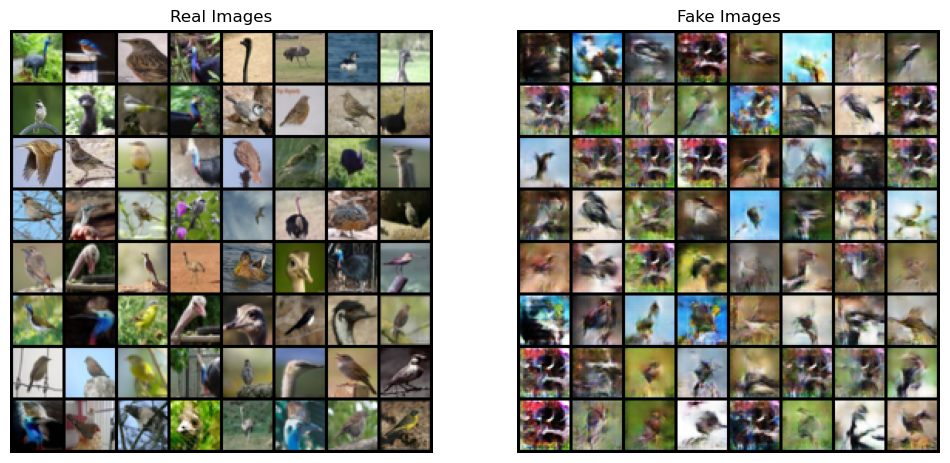

In [34]:
batch = next(iter(bird_trainloader))
 
plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(batch[0][:64], normalize=True),(1,2,0))) #We can set normalize=True to de-normalise the images automatically
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(images[-1], (1, 2, 0)))
plt.show()

Here we can observe a snippet of our final output. While the birds generated by our GAN are certainly not indistinguishable from real images, the model has done a relatively decent job of generating a range of different birds similar to that of our training set. 

### Visualising GAN Training Process

![Alt Text](gan_training_batch.gif)

Here is a visualisation in GIF form of our model training process. As we can see, the images start off as noise but quickly form into bird like shapes, before slowly becoming more and more similar to a bird as iterations continue.

## Conclusion

### Distinctive Features

In this project, I wanted to go over the complex features of a GAN but didn't want to throw users into the deep end with an overwhelming amount of information to learn at once. As such, I tried to go for a gradual buildup, where we start off small with the data handling, and building a simple CNN model, before ramping up the intensity to a better, more involved model, and finally utilising this structure in a subsequent GAN. In terms of other projects online, I think the benefit here is a shallower learning curve, allowing readers to 'dip their toes' first before going into the deep end which covers it well, but can be overwhelming<sup>[15]</sup>. This does, however, lead to certain cons, specifically in that squeezing all this content in means that it is rather surface level compared to some tutorials that stick to their own field, such as <sup>[16]</sup> where there is more comprehensive information each section. This tutorial was developed with CNNs at the forefront, and as such, lacks a deep tutorial on the inner workings of a GAN, and as such may not be as useful to users looking for a complete explanation of these systems. The GAN also wasn't optimised in much detail in an attempt to not overcomplicate the tutorial and as a result, it is lacking certain features offered in other networks, such as leaky ReLu in this example<sup>[17]</sup> which is shown to be useful in GANs. Despite this, I still believe this project offers a good stepping stone into the world of CNNs and GANs, while not necessarily covering everything about them.

## References

1 - https://www.cs.toronto.edu/~kriz/cifar.html \
2 - https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/ \
3 - https://pytorch.org/vision/0.17/generated/torchvision.datasets.CIFAR10.html \
4-  https://datacarpentry.org/image-processing/05-creating-histograms.html \
5 - https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/    \
6 - https://www.geeksforgeeks.org/activation-functions-neural-networks    \
7 - https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2 \
8 - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html \
9 - https://www.datacamp.com/tutorial/the-cross-entropy-loss-function-in-machine-learning \
10 - https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=An%20optimizer%20is%20a%20function,overall%20loss%20and%20improving%20accuracy \
11 - https://www.geeksforgeeks.org/activation-functions-neural-networks \
12 - https://developers.google.com/machine-learning/gan/gan_structure \
13 - https://developers.google.com/machine-learning/gan/problems \
14 - https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html \
15 - https://realpython.com/generative-adversarial-networks/ \
16 - https://livebook.manning.com/book/deep-learning-with-pytorch/chapter-7/v-13/166 \
17 - https://github.com/sachinruk/deepschool.io/blob/master/DL-Keras_Tensorflow/Lesson%2021%20-%20Generative%20Adversarial%20Networks.ipynb \
18 - https://github.com/sachinruk/deepschool.io/blob/master/DL-Keras_Tensorflow/Lesson%2012%20-%20CIFAR10%20CNN%20-%20Solutions.ipynb \
19 - https://www.youtube.com/watch?v=r6yRAxDpamQ&list=PLCC34OHNcOtpcgR9LEYSdi9r7XIbpkpK1&index=16 \
20 - https://www.youtube.com/watch?v=dGLPvNhjs4U&t=445s